# Figure 4

In this notebook, we'll generate figure panels for use in Figure 4, the overview of Lenalidomide treatment results.

For the UMAP plots, see the notebook for Figure 1. In this notebook, we'll generate the differential result barplots, Hallmark Pathway heatmaps, and motif enrichment volcano plots.

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
ggrepel: text plotting with repulsion  
cowplot: multi-panel plot assembly

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(ggrepel)
quiet_library(cowplot)

In [2]:
out_dir <- "output/figure_4"
if(!dir.exists(out_dir)) { dir.create(out_dir, recursive = TRUE) }

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the analysis results for DEG, Hallmark Pathway enrichment, and motif enrichment.

DEG: Differentially expressed genes

In [3]:
deg_uuid <- list("fc83b89f-fd26-43b8-ac91-29c539703a45")

In [4]:
deg_fres <- cacheFiles(deg_uuid)
deg_file <- list.files(
    paste0("cache/",deg_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



DEP: Differentially expressed proteins (ADT)

In [5]:
dep_uuid <- list("4cbaa9ab-f8ef-495d-ac5e-1f1d99d33e33")

In [6]:
dep_fres <- cacheFiles(dep_uuid)
dep_file <- list.files(
    paste0("cache/",dep_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



DAP: Differentially accessible peaks (ATAC)

In [7]:
dap_uuid <- list("a8973524-cc71-40d5-8edf-3d6a9e0a77d4")

In [8]:
dap_fres <- cacheFiles(dap_uuid)
dap_file <- list.files(
    paste0("cache/",dap_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



In [9]:
hallmark_uuid <- list("4f05f2a0-59d2-4d04-b948-70d541613e71")

In [10]:
hallmark_fres <- cacheFiles(hallmark_uuid)
hallmark_file <- list.files(
    paste0("cache/",hallmark_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



In [11]:
dem_uuid <- list("42adb44f-71d2-4d8b-a80c-73b0833d6a1d")

In [12]:
dem_fres <- cacheFiles(dem_uuid)
dem_file <- list.files(
    paste0("cache/",dem_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



## Differential expression barplots

### DEG Barplots

In [13]:
fdr_cutoff <- 0.05

In [14]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

In [15]:
all_deg <- read.csv(deg_file)

In [16]:
all_deg <- all_deg %>%
  mutate(
      direction_sign = ifelse(
          is.na(logFC),
          sign(coef_D),
          sign(logFC)
      ),
      direction = ifelse(
          direction_sign == 1,
          "up", "dn"
      )
  )

In [17]:
all_deg <- all_deg %>%
  filter(fg == "lenalidomide")

In [18]:
deg_summary <- all_deg %>%
  group_by(fg, timepoint, aifi_cell_type, n_sample) %>%
  summarise(n_sig = sum(adjP < fdr_cutoff),
            n_up = sum(adjP < fdr_cutoff & direction == "up"),
            n_dn = sum(adjP < fdr_cutoff & direction == "dn"),
            .groups = "keep")

In [19]:
plot_data <- deg_summary %>%
  rename(aifi_cell_type = aifi_cell_type) %>%
  left_join(type_colors) %>%
  mutate(treat_time = paste0(fg,"_",timepoint)) %>%
  group_by(fg) %>%
  mutate(max_val = max(c(n_up, n_dn))) %>%
  ungroup()

Joining with `by = join_by(aifi_cell_type)`


In [20]:
plot_data %>%
  filter(fg == "lenalidomide",
         aifi_cell_type == "t_cd4_naive")

fg,timepoint,aifi_cell_type,n_sample,n_sig,n_up,n_dn,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos,treat_time,max_val
<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>
lenalidomide,4,t_cd4_naive,1352,292,210,82,CD4 Naive,#93A7D1,1,7,lenalidomide_4,570
lenalidomide,24,t_cd4_naive,1352,1046,570,476,CD4 Naive,#93A7D1,1,7,lenalidomide_24,570
lenalidomide,72,t_cd4_naive,1352,454,265,189,CD4 Naive,#93A7D1,1,7,lenalidomide_72,570


In [21]:
write.csv(
    plot_data,
    file.path(out_dir, paste0("lenalidomide_deg_summary_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

In [22]:
treat_times <- paste0("lenalidomide_", c(4, 24, 72))

In [23]:
options(repr.plot.width = 12, repr.plot.height = 4)
treat_plots <- map(
    treat_times,
    function(tt) {
                
        pd <- plot_data %>%
          filter(treat_time == tt)
        
        x_max <- pd$max_val[1]
        x_min <- -1 * x_max
        x_breaks <- unique(c(seq(signif(x_min, 1), 0, length.out = 3),
                             seq(0, signif(x_max, 1), length.out = 3)))
        
        timepoint <- pd$timepoint[1]
        pd_max <- max(max(pd$n_dn), max(pd$n_up))
        if(pd_max < 100) {
            pd_max <- 100
        }
        
        up_pd <- pd %>%
          mutate(xmin = 0, xmax = n_up,
                 fill = "orangered")
        dn_pd <- pd %>%
          mutate(xmin = -1 * n_dn, xmax = 0,
                 fill = "dodgerblue")
        
        pd <- rbind(up_pd, dn_pd)
        
        plot_ypos <- pd %>%
          select(aifi_cell_type, cell_type_label, 
                 cell_type_color, cell_type_ypos, 
                 n_sample, n_sig) %>%
          unique()
        
        p <- ggplot()
        
        if(timepoint == 4) {
            x_lim <- c(x_min * 3.5, x_max * 1.1)
            
            p <- p + geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 3.5, xmax = x_min * 1.1,
                        fill = cell_type_color),
                    alpha = 0.8) +
            geom_text(data = plot_ypos,
                    aes(x = x_min * 1.6, y = cell_type_ypos,
                        label = cell_type_label),
                    hjust = 1,
                    vjust = 0.5) +
            geom_text(data = plot_ypos,
                    aes(x = x_min * 1.2, y = cell_type_ypos,
                        label = n_sample),
                    hjust = 1)
            
        } else {
            x_lim <- c(x_min * 1.1, x_max * 1.1)
        }
        p <- p +
          geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 1.1, xmax = x_max * 1.1,
                        fill = cell_type_color),
                    alpha = 0.3) +
          geom_rect(data = pd,
                   aes(ymin = cell_type_ypos - 0.35, ymax = cell_type_ypos + 0.35,
                       xmin = xmin, xmax = xmax,
                       fill = fill)) +
          geom_vline(data = data.frame(x = 0),
                     aes(xintercept = x)) +
          scale_y_continuous("",
                             limits = c(min(plot_ypos$cell_type_ypos) - 0.5, max(plot_ypos$cell_type_ypos) + 0.5)) +
          scale_fill_identity() +
          scale_x_continuous(paste0("N DEGs\n(FDR < ",fdr_cutoff,")"),
                             limits = x_lim,
                             breaks = x_breaks,
                             expand = c(0,0)) +
          theme_bw(base_size = 16) +
          facet_wrap(~ timepoint, ncol = 3) +
          theme(panel.grid.major.y = element_blank(),
                panel.grid.minor = element_blank(),
                axis.ticks = element_blank(),
                axis.text.y = element_blank(),
                panel.border = element_blank(),
                strip.background = element_blank())
        
        p
    }
)
names(treat_plots) <- treat_times

In [24]:
treat_times

[1] "lenalidomide_4"  "lenalidomide_24" "lenalidomide_72"

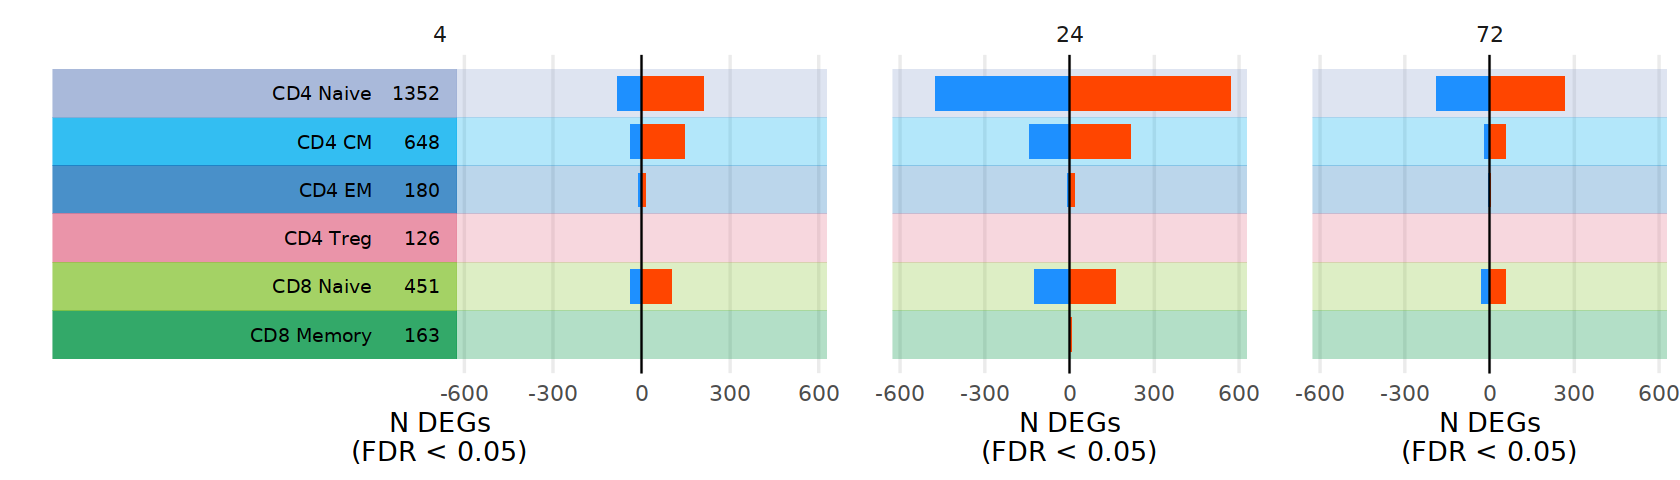

In [25]:
options(repr.plot.width = 14, repr.plot.height = 4)
all_plots <- plot_grid(
    plotlist = treat_plots,
    nrow = 1, ncol = 3,
    rel_widths = c(2,1,1)
)
all_plots

In [26]:
out_file <- file.path(
    out_dir,
    paste0("lenalidomide_deg_barplot_",Sys.Date(),".pdf")
)
ggsave(out_file,
       all_plots,
       width = 14, height = 4)

### DAP Barplots

In [27]:
fdr_cutoff <- 0.05

In [28]:
all_dap <- read.csv(dap_file)

In [29]:
head(all_dap)

,aifi_cell_type,fg,bg,seqnames,start,end,logFC,adjP,MeanDiff,idx
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,t_cd4_cm,bortezomib_4,dmso_4,chr1,817097,817597,0.76247158,0.9617006,0.016549055,1
2,t_cd4_cm,bortezomib_4,dmso_4,chr1,827316,827816,-0.01214597,0.9617006,-0.002062272,2
3,t_cd4_cm,bortezomib_4,dmso_4,chr1,844402,844902,-0.72051897,0.9617006,-0.017751078,3
4,t_cd4_cm,bortezomib_4,dmso_4,chr1,903980,904480,-1.17605733,0.9617006,-0.016888331,6
5,t_cd4_cm,bortezomib_4,dmso_4,chr1,904495,904995,-0.21563641,0.9617006,-0.040113108,7
6,t_cd4_cm,bortezomib_4,dmso_4,chr1,942207,942707,-0.89654326,0.9617006,-0.042661663,16


In [30]:
all_dap <- all_dap %>%
  mutate(timepoint = sub(".+_","",fg),
         fg = sub("_.+","",fg),
         bg = sub("_.+","",bg)) %>%
  filter(fg == "lenalidomide") %>%
  mutate(direction = ifelse(logFC > 0, "up", "dn"))

In [31]:
head(all_dap)

,aifi_cell_type,fg,bg,seqnames,start,end,logFC,adjP,MeanDiff,idx,timepoint,direction
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,t_cd4_cm,lenalidomide,dmso,chr1,236604238,236604738,2.093293,2.882234e-15,0.4113537,7199,4,up
2,t_cd4_cm,lenalidomide,dmso,chr15,67150342,67150842,2.729955,1.124049e-13,0.3793228,1193,4,up
3,t_cd4_cm,lenalidomide,dmso,chr1,234724186,234724686,1.546861,1.971491e-13,0.4868936,7081,4,up
4,t_cd4_cm,lenalidomide,dmso,chr7,6374176,6374676,1.321119,1.971491e-13,0.5133141,402,4,up
5,t_cd4_cm,lenalidomide,dmso,chr11,68471843,68472343,1.945509,2.084277e-12,0.4141671,2388,4,up
6,t_cd4_cm,lenalidomide,dmso,chr8,100502290,100502790,2.426262,5.581893e-12,0.3728084,1573,4,up


In [32]:
table(all_dap$aifi_cell_type)


    t_cd4_cm     t_cd4_em  t_cd4_naive   t_cd4_treg t_cd8_memory  t_cd8_naive 
      217715       212987       202190       175052       203978       217988 

In [33]:
dap_summary <- all_dap %>%
  group_by(fg, timepoint, aifi_cell_type) %>%
  summarise(n_sig = sum(adjP < fdr_cutoff),
            n_up = sum(adjP < fdr_cutoff & direction == "up"),
            n_dn = sum(adjP < fdr_cutoff & direction == "dn"),
            .groups = "keep")

In [34]:
head(dap_summary)

fg,timepoint,aifi_cell_type,n_sig,n_up,n_dn
<chr>,<chr>,<chr>,<int>,<int>,<int>
lenalidomide,24,t_cd4_cm,2771,2155,616
lenalidomide,24,t_cd4_em,3197,2532,665
lenalidomide,24,t_cd4_naive,2325,1787,538
lenalidomide,24,t_cd4_treg,41,38,3
lenalidomide,24,t_cd8_memory,2526,2064,462
lenalidomide,24,t_cd8_naive,3252,2492,760


In [35]:
plot_data <- dap_summary %>%
  left_join(type_colors) %>%
  mutate(treat_time = paste0(fg,"_",timepoint)) %>%
  group_by(fg) %>%
  mutate(max_val = max(c(n_up, n_dn))) %>%
  ungroup()

Joining with `by = join_by(aifi_cell_type)`


In [36]:
plot_data %>%
  filter(fg == "lenalidomide",
         aifi_cell_type == "t_cd4_naive")

fg,timepoint,aifi_cell_type,n_sig,n_up,n_dn,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos,treat_time,max_val
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>
lenalidomide,24,t_cd4_naive,2325,1787,538,CD4 Naive,#93A7D1,1,7,lenalidomide_24,2532
lenalidomide,4,t_cd4_naive,511,482,29,CD4 Naive,#93A7D1,1,7,lenalidomide_4,2532
lenalidomide,72,t_cd4_naive,354,312,42,CD4 Naive,#93A7D1,1,7,lenalidomide_72,2532


In [37]:
write.csv(
    plot_data,
    file.path(out_dir, paste0("lenalidomide_dap_summary_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

In [38]:
treat_times <- paste0("lenalidomide_", c(4, 24, 72))

In [39]:
options(repr.plot.width = 12, repr.plot.height = 4)
treat_plots <- map(
    treat_times,
    function(tt) {
        
        pd <- plot_data %>%
          filter(treat_time == tt)
        
        x_max <- pd$max_val[1]
        x_min <- -1 * x_max
        x_breaks <- unique(c(seq(signif(x_min, 1), 0, length.out = 3),
                             seq(0, signif(x_max, 1), length.out = 3)))
        x_max <- max(x_max, x_breaks[length(x_breaks)])
        x_min <- min(x_min, x_breaks[1])
        
        timepoint <- pd$timepoint[1]

        up_pd <- pd %>%
          mutate(xmin = 0, xmax = n_up,
                 fill = "orangered")
        dn_pd <- pd %>%
          mutate(xmin = -1 * n_dn, xmax = 0,
                 fill = "dodgerblue")
        
        pd <- rbind(up_pd, dn_pd)
        
        plot_ypos <- pd %>%
          select(aifi_cell_type, cell_type_label, 
                 cell_type_color, cell_type_ypos, 
                 n_sig) %>%
          unique()
        
        p <- ggplot()
        
        if(timepoint == 4) {
            x_lim <- c(x_min * 3.5, x_max * 1.1)
            
            p <- p + geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 3.5, xmax = x_min * 1.1,
                        fill = cell_type_color),
                    alpha = 0.8) +
            geom_text(data = plot_ypos,
                    aes(x = x_min * 1.6, y = cell_type_ypos,
                        label = cell_type_label),
                    hjust = 1,
                    vjust = 0.5)
            
        } else {
            x_lim <- c(x_min * 1.1, x_max * 1.1)
        }
        p <- p +
          geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 1.1, xmax = x_max * 1.1,
                        fill = cell_type_color),
                    alpha = 0.3) +
          geom_rect(data = pd,
                   aes(ymin = cell_type_ypos - 0.35, ymax = cell_type_ypos + 0.35,
                       xmin = xmin, xmax = xmax,
                       fill = fill)) +
          geom_vline(data = data.frame(x = 0),
                     aes(xintercept = x)) +
          scale_y_continuous("",
                             limits = c(min(plot_ypos$cell_type_ypos) - 0.5, max(plot_ypos$cell_type_ypos) + 0.5)) +
          scale_fill_identity() +
          scale_x_continuous(paste0("N DAPs\n(FDR < ",fdr_cutoff,")"),
                             limits = x_lim,
                             breaks = x_breaks,
                             expand = c(0,0)) +
          theme_bw(base_size = 16) +
          facet_wrap(~ timepoint, ncol = 3) +
          theme(panel.grid.major.y = element_blank(),
                panel.grid.minor = element_blank(),
                axis.ticks = element_blank(),
                axis.text.y = element_blank(),
                panel.border = element_blank(),
                strip.background = element_blank())
        
        p
    }
)
names(treat_plots) <- treat_times

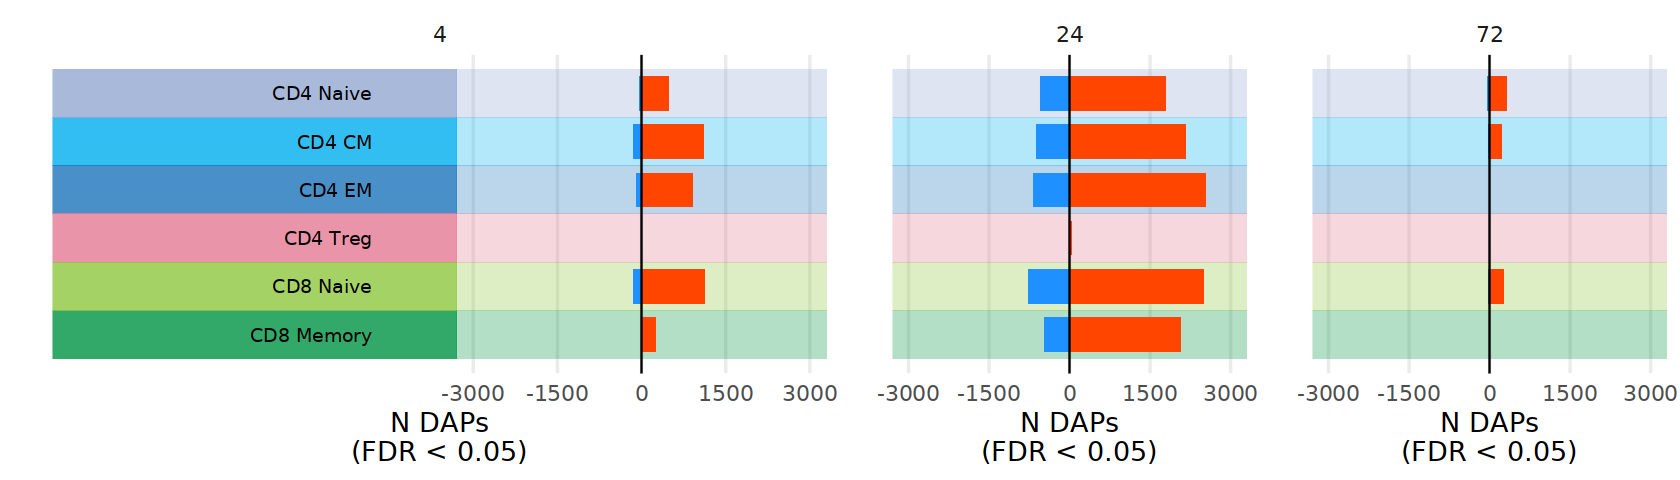

In [40]:
options(repr.plot.width = 14, repr.plot.height = 4)
all_plots <- plot_grid(
    plotlist = treat_plots,
    nrow = 1, ncol = 3,
    rel_widths = c(2,1,1)
)
all_plots

In [41]:
out_file <- file.path(
    out_dir,
    paste0("lenalidomide_dap_barplot_",Sys.Date(),".pdf")
)
ggsave(out_file,
       all_plots,
       width = 14, height = 4)

### DDE Barplots
Differentially detected epitopes, aka Differentially expressed proteins (DEP)

In [42]:
fdr_cutoff <- 0.05

In [43]:
all_dep <- read.csv(dep_file)

In [44]:
all_dep <- all_dep %>%
  filter(fg == "lenalidomide") %>%
  mutate(direction = ifelse(logFC > 0, "up", "dn"))

In [45]:
dep_epitope_summary <- all_dep %>%
  filter(adjP < fdr_cutoff) %>%
  group_by(fg, feature, direction) %>%
  summarise(n_types_up = n(), .groups = "keep")

In [46]:
dep_summary <- all_dep %>%
  group_by(fg, timepoint, aifi_cell_type) %>%
  summarise(n_sig = sum(adjP < fdr_cutoff),
            n_up = sum(adjP < fdr_cutoff & direction == "up"),
            n_dn = sum(adjP < fdr_cutoff & direction == "dn"),
            .groups = "keep")

In [47]:
plot_data <- dep_summary %>%
  left_join(type_colors) %>%
  mutate(treat_time = paste0(fg,"_",timepoint)) %>%
  group_by(fg) %>%
  mutate(max_val = max(c(n_up, n_dn))) %>%
  ungroup()

Joining with `by = join_by(aifi_cell_type)`


In [48]:
plot_data %>%
  filter(fg == "lenalidomide",
         aifi_cell_type == "t_cd4_naive")

fg,timepoint,aifi_cell_type,n_sig,n_up,n_dn,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos,treat_time,max_val
<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>
lenalidomide,4,t_cd4_naive,2,0,2,CD4 Naive,#93A7D1,1,7,lenalidomide_4,7
lenalidomide,24,t_cd4_naive,4,2,2,CD4 Naive,#93A7D1,1,7,lenalidomide_24,7
lenalidomide,72,t_cd4_naive,10,3,7,CD4 Naive,#93A7D1,1,7,lenalidomide_72,7


In [49]:
write.csv(
    plot_data,
    file.path(out_dir, paste0("lenalidomide_dde_summary_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

In [50]:
treat_times <- paste0("lenalidomide_", c(4, 24, 72))

In [51]:
options(repr.plot.width = 12, repr.plot.height = 4)
treat_plots <- map(
    treat_times,
    function(tt) {
        
        pd <- plot_data %>%
          filter(treat_time == tt)
        
        x_max <- pd$max_val[1]
        x_min <- -1 * x_max
        x_breaks <- unique(c(seq(signif(x_min, 1), 0, length.out = 3),
                             seq(0, signif(x_max, 1), length.out = 3)))
        
        timepoint <- pd$timepoint[1]
        
        up_pd <- pd %>%
          mutate(xmin = 0, xmax = n_up,
                 fill = "orangered")
        dn_pd <- pd %>%
          mutate(xmin = -1 * n_dn, xmax = 0,
                 fill = "dodgerblue")
        
        pd <- rbind(up_pd, dn_pd)
        
        plot_ypos <- pd %>%
          select(aifi_cell_type, cell_type_label, 
                 cell_type_color, cell_type_ypos, 
                 n_sig) %>%
          unique()
        
        p <- ggplot()
        
        if(timepoint == 4) {
            x_lim <- c(x_min * 3.5, x_max * 1.1)
            
            p <- p + geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 3.5, xmax = x_min * 1.1,
                        fill = cell_type_color),
                    alpha = 0.8) +
            geom_text(data = plot_ypos,
                    aes(x = x_min * 1.6, y = cell_type_ypos,
                        label = cell_type_label),
                    hjust = 1,
                    vjust = 0.5)
            
        } else {
            x_lim <- c(x_min * 1.1, x_max * 1.1)
        }
        p <- p +
          geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 1.1, xmax = x_max * 1.1,
                        fill = cell_type_color),
                    alpha = 0.3) +
          geom_rect(data = pd,
                   aes(ymin = cell_type_ypos - 0.35, ymax = cell_type_ypos + 0.35,
                       xmin = xmin, xmax = xmax,
                       fill = fill)) +
          geom_vline(data = data.frame(x = 0),
                     aes(xintercept = x)) +
          scale_y_continuous("",
                             limits = c(min(plot_ypos$cell_type_ypos) - 0.5, max(plot_ypos$cell_type_ypos) + 0.5)) +
          scale_fill_identity() +
          scale_x_continuous(paste0("N DDEs\n(FDR < ",fdr_cutoff,")"),
                             limits = x_lim,
                             breaks = x_breaks,
                             expand = c(0,0)) +
          theme_bw(base_size = 16) +
          facet_wrap(~ timepoint, ncol = 3) +
          theme(panel.grid.major.y = element_blank(),
                panel.grid.minor = element_blank(),
                axis.ticks = element_blank(),
                axis.text.y = element_blank(),
                panel.border = element_blank(),
                strip.background = element_blank())
        
        p
    }
)
names(treat_plots) <- treat_times

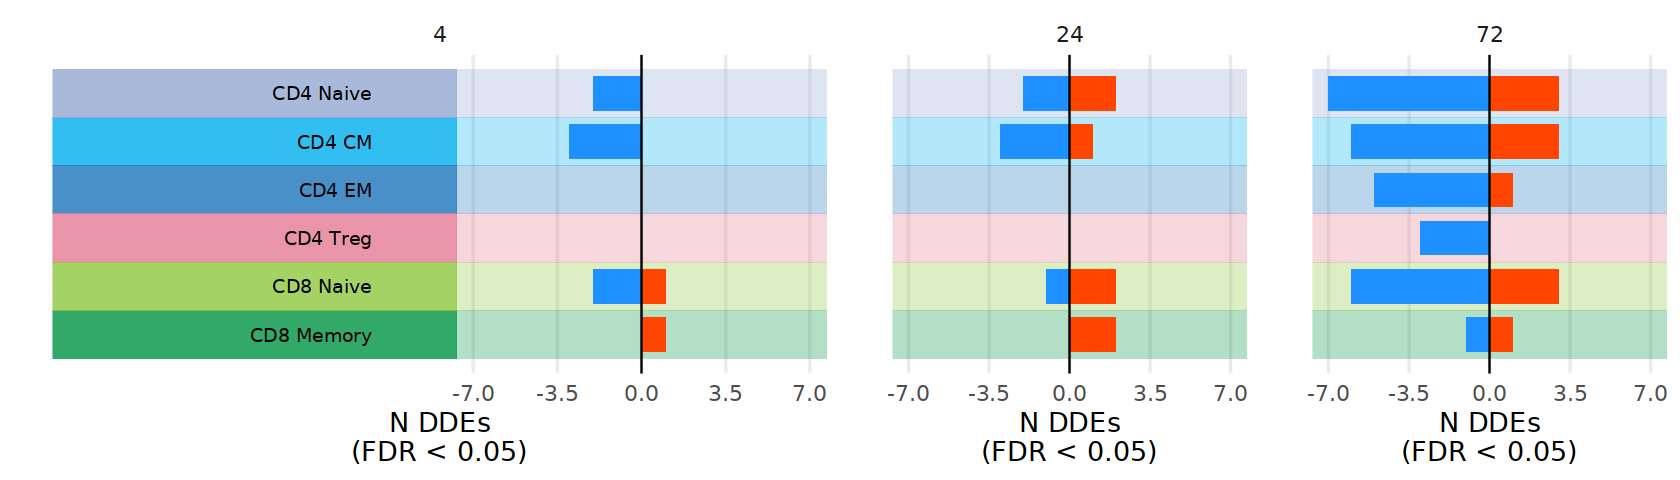

In [52]:
options(repr.plot.width = 14, repr.plot.height = 4)
all_plots <- plot_grid(
    plotlist = treat_plots,
    nrow = 1, ncol = 3,
    rel_widths = c(2,1,1)
)
all_plots

In [53]:
out_file <- file.path(
    out_dir,
    paste0("lenalidomide_dde_barplot_",Sys.Date(),".pdf")
)
ggsave(out_file,
       all_plots,
       width = 14, height = 4)

## Hallmark pathway enrichment heatmaps

In [54]:
fdr_cutoff <- 0.05

In [55]:
hallmark_names <- read.csv("../common/gene_sets/hallmark_names.csv")

In [56]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

Gradient colors

In [57]:
lo_gc <- data.frame(NES = seq(-3, -1.01, 0.01)) %>%
  mutate(nes_color = colorRampPalette(c("darkblue", "skyblue"))(n()))
mid_lo_gc <- data.frame(NES = seq(-1, 0, 0.01), nes_color = "gray80")
hi_gc <- data.frame(NES = seq(3,1.01,-0.01)) %>%
  mutate(nes_color = colorRampPalette(c("darkred", "coral"))(n()))
mid_hi_gc <- data.frame(NES = seq(1, 0.01, -0.01), nes_color = "gray80")

gc_df <- do.call(rbind, list(lo_gc, mid_lo_gc, mid_hi_gc, hi_gc))
gc_df$NES <- as.character(gc_df$NES)

In [58]:
all_hallmark <- read.csv(hallmark_file)

In [59]:
all_hallmark <- all_hallmark %>%
  filter(fg == "lenalidomide")

In [60]:
head(all_hallmark)

,fg,bg,timepoint,aifi_cell_type,pathway_label,NES,nomP,adjP,n_leadingEdge,n_pathway_genes,leadingEdge,pathway_genes
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>
1,lenalidomide,dmso,24,t_cd4_cm,Notch Signaling,1.517715,0.06371681,0.4571429,15,34,SAP30;TCF7L2;CUL1;RBX1;ARRB1,APH1A;ARRB1;CCND1;CUL1;DLL1;DLL1;DTX1;DTX2;DTX2;DTX4;FBXW11;FZD1;FZD5;FZD7;HES1;HEYL;JAG1;KAT2A;LFNG;MAML2;NOTCH1;NOTCH2;NOTCH3;PPARD;PRKCA;PSEN2;PSENEN;RBX1;SAP30;SKP1;ST3GAL6;TCF7L2;WNT2;WNT5A
2,lenalidomide,dmso,24,t_cd4_cm,Protein Secretion,1.509987,0.04588608,0.4571429,83,98,ATP1A1;SEC24D;DST;VPS4B;SEC31A;BET1;TPD52;ZW10;CLN5;ADAM10;LAMP2;TMX1;CD63;VAMP4;PAM;RAB5A;USO1;STX7;TMED2;ARFGAP3;LMAN1;RAB14;IGF2R;STX12;ARF1;TOM1L1;PPT1,ABCA1;ADAM10;ANP32E;AP1G1;AP2B1;AP2M1;AP2S1;AP3B1;AP3S1;ARCN1;ARF1;ARFGAP3;ARFGEF1;ARFGEF2;ARFIP1;ATP1A1;ATP6V1B1;ATP6V1H;ATP7A;BET1;BNIP3;CAV2;CD63;CLCN3;CLN5;CLTA;CLTC;COG2;COPB1;COPB2;COPE;CTSC;DNM1L;DOP1A;DST;EGFR;ERGIC3;GALC;GBF1;GLA;GNAS;GOLGA4;GOSR2;ICA1;IGF2R;KIF1B;KRT18;LAMP2;LMAN1;M6PR;MAPK1;MON2;NAPA;NAPG;OCRL;PAM;PPT1;RAB14;RAB22A;RAB2A;RAB5A;RAB9A;RER1;RPS6KA3;SCAMP1;SCAMP3;SCAMP3;SCRN1;SEC22B;SEC24D;SEC31A;SGMS1;SH3GL2;SNAP23;SNX2;SOD1;SSPN;STAM;STX12;STX16;STX7;TMED10;TMED2;TMX1;TOM1L1;TPD52;TSG101;TSPAN8;USO1;VAMP3;VAMP4;VAMP7;VPS45;VPS45;VPS4B;YIPF6;YKT6;ZW10
3,lenalidomide,dmso,24,t_cd4_cm,KRAS Signaling UP,1.459297,0.06666667,0.4571429,67,220,IKZF1;GALNT3;HBEGF;PRDM1;LAPTM5,ABCB1;ACE;ADAM17;ADAM8;ADAMDEC1;ADGRA2;ADGRL4;AKAP12;AKT2;ALDH1A2;ALDH1A3;AMMECR1;ANGPTL4;ANKH;ANO1;ANXA10;APOD;ARG1;ATG10;AVL9;BIRC3;BMP2;BPGM;BTBD3;BTC;C3AR1;CA2;CAB39L;CBL;CBR4;CBX8;CCL20;CCND2;CCSER2;CD37;CDADC1;CFB;CFB;CFB;CFB;CFB;CFB;CFB;CFH;CFHR2;CIDEA;CLEC4A;CMKLR1;CPE;CROT;CSF2;CSF2RA;CTSS;CXCL10;CXCR4;DCBLD2;DNMBP;DOCK2;DUSP6;EMP1;ENG;EPB41L3;EPHB2;EREG;ERO1A;ETS1;ETV1;ETV4;ETV5;EVI5;F13A1;F2RL1;FBXO4;FCER1G;FGF9;FLT4;FUCA1;G0S2;GABRA3;GADD45G;GALNT3;GFPT2;GLRX;GNG11;GPNMB;GPRC5B;GUCY1A1;GYPC;H2BC3;HBEGF;HDAC9;HKDC1;HOXD11;HSD11B1;ID2;IGF2;IGFBP3;IKZF1;IL10RA;IL1B;IL1RL2;IL2RG;IL33;IL7R;INHBA;IRF8;ITGA2;ITGB2;ITGBL1;JUP;KCNN4;KIF5C;KIF5C;KLF4;LAPTM5;LAT2;LCP1;LIF;LY96;MAFB;MALL;MAP3K1;MAP4K1;MAP4K1;MAP7;MMD;MMP10;MMP11;MMP11;MMP9;MPZL2;MTMR10;MTMR10;MYCN;NAP1L2;NGF;NIN;NR0B2;NR1H4;NRP1;PCP4;PCSK1N;PDCD1LG2;PECAM1;PEG3;PIGR;PLAT;PLAU;PLAUR;PLEK2;PLVAP;PPBP;PPP1R15A;PRDM1;PRELID3B;PRKG2;PRRX1;PSMB8;PSMB8;PSMB8;PSMB8;PSMB8;PSMB8;PSMB8;PSMB8;PTBP2;PTCD2;PTGS2;PTPRR;RABGAP1L;RBM4;RBP4;RELN;RETN;RGS16;SATB1;SCG3;SCG5;SCG5;SCG5;SCN1B;SDCCAG8;SDCCAG8;SEMA3B;SERPINA3;SLPI;SNAP25;SNAP91;SOX9;SPARCL1;SPON1;SPP1;SPRY2;ST6GAL1;STRN;TFPI;TLR8;TMEM100;TMEM158;TMEM176A;TMEM176B;TNFAIP3;TNFRSF1B;TNNT2;TOR1AIP2;TPH1;TRAF1;TRIB1;TRIB2;TSPAN1;TSPAN13;TSPAN7;USH1C;USP12;VWA5A;WDR33;WNT7A;YRDC;ZNF277;ZNF639
4,lenalidomide,dmso,24,t_cd4_cm,Spermatogenesis,1.452788,0.06429780,0.4571429,39,144,EZH2;CAMK4;TOPBP1;STRBP;CHFR,ACE;ACRBP;ACRV1;ACTL7B;ADAD1;ADAM2;ADAM2;ADCYAP1;AGFG1;AKAP4;ALOX15;ARL4A;ART3;AURKA;BRAF;BUB1;CAMK4;CCNA1;CCNB2;CCT6B;CDK1;CDKN3;CFTR;CHFR;CHRM4;CLGN;CLPB;CLVS1;CNIH2;COIL;CRISP2;CSNK2A2;CST8;DBF4;DCC;DDX25;DDX4;DMC1;DMRT1;DNAJB8;DPEP3;ELOVL3;EZH2;GAD1;GAPDHS;GFI1;GMCL1;GPR182;GRM8;GSG1;GSTM3;H1-6;HBZ;HOXB1;HSPA1L;HSPA1L;HSPA1L;HSPA1L;HSPA1L;HSPA2;HSPA4L;HTR5A;IDE;IFT88;IL12RB2;IL13RA2;IP6K1;JAM3;KIF2C;LDHC;LPIN1;MAP7;MAST2;MEP1B;MLF1;MLLT10;MTNR1A;MTOR;NAA11;NCAPH;NEFH;NEK2;NF2;NOS1;NPHP1;NPY5R;OAZ3;ODF1;PACRG;PAPOLB;PARP2;PCSK1N;PCSK4;PDHA2;PEBP1;PGK2;PGS1;PHF7;PHKG2;PIAS2;POMC;PRKAR2A;PRM2;PSMG1;RAD17;RAD17;RFC4;RPL39L;SCG3;SCG5;SCG5;SCG5;SEPTIN4;SHE;SIRT1;SLC12A2;SLC2A5;SNAP91;SPATA6;STAM2;STRBP;SYCP1;TALDO1;TCP11;TEKT2;THEG;TKTL1;TLE4;TNNI3;TNP1;TNP2;TOPBP1;TSN;TSSK2;TTK;TUBA3C;TULP2;VDAC3;YBX2;YBX2;ZC2HC1C;ZC3H14;ZNRF4;ZPBP
5,lenalidomide,dmso,24,t_cd4_cm,Unfolded Protein Response,1.390092,0.08763693,0.5244584,87,115,TSPYL2;PDIA5;ERN1;SEC31A;DNAJC3;XBP1;SRPRA;DNAJB9;SERP1;SLC30A5;EXOSC5;NFYA;SEC11A;HSP90B1;PDIA6;SRPRB;ATF6;DCP2;IMP3,ALDH18A1;ARFGAP1;ASNS;ATF3;ATF4;ATF6;ATP6V0D1;BAG3;BANF1;CALR;CCL2;CEBPB

Add treat_time, display labels for pathways, and cell type 

In [61]:
plot_hallmark <- all_hallmark %>%
  mutate(label_time = ifelse(timepoint == 4, "04", as.character(timepoint))) %>%
  mutate(treat_time = paste0(fg, "_", label_time)) %>%
  left_join(hallmark_names) %>%
  left_join(type_colors)

Joining with `by = join_by(pathway_label)`
Joining with `by = join_by(aifi_cell_type)`


In [62]:
top_n <- 20

sig_data <- plot_hallmark %>%
  filter(adjP < fdr_cutoff) %>%
  group_by(pathway) %>%
  arrange(adjP) %>%
  slice(1) %>%
  ungroup() %>%
  arrange(adjP) %>%
  head(top_n)

plot_data <- plot_hallmark %>%
  filter(pathway %in% sig_data$pathway)

xpos_df <- plot_data %>%
  select(cell_type_label, cell_type_xpos) %>%
  unique() %>%
  arrange(cell_type_xpos) %>%
  mutate(xpos = 1:n())

ypos_df <- plot_data %>%
  select(pathway_label) %>%
  unique() %>%
  arrange(pathway_label) %>%
  mutate(ypos = n():1)

timepoint_df <- data.frame(
    timepoint = c(4, 24, 72),
    timepoint_label = factor(c("Lenalidomide, 4 Hours", "Lenalidomide, 24 Hours", "Lenalidomide, 72 Hours"), 
                             levels = c("Lenalidomide, 4 Hours", "Lenalidomide, 24 Hours", "Lenalidomide, 72 Hours"))
)

plot_data <- plot_data %>%
  left_join(xpos_df) %>%
  left_join(ypos_df) %>%
  mutate(NES = as.character(round(NES, 2))) %>%
  left_join(gc_df) %>%
  left_join(timepoint_df)

Joining with `by = join_by(cell_type_label, cell_type_xpos)`
Joining with `by = join_by(pathway_label)`
Joining with `by = join_by(NES)`
Joining with `by = join_by(timepoint)`


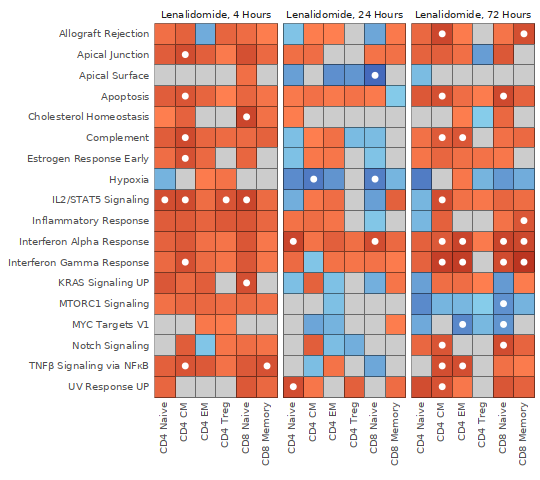

In [63]:
options(repr.plot.width = 4.5, repr.plot.height = 4)
hallmark_plot <- ggplot() +
  geom_tile(
      data = plot_data,
      aes(x = xpos,
          y = ypos,
          fill = nes_color),
      color = "black") +
  geom_point(
      data = plot_data %>% filter(adjP < fdr_cutoff),
      aes(x = xpos,
          y = ypos),
      color = "white",
      size = 0.9) +
  scale_fill_identity() +
  scale_x_continuous(
      "",
      breaks = xpos_df$xpos,
      labels = xpos_df$cell_type_label,
      expand = c(0, 0)) +
  scale_y_continuous(
      "",
      breaks = ypos_df$ypos,
      labels = ypos_df$pathway_label,
      expand = c(0, 0)) +
  facet_wrap(~ timepoint_label) +
  theme_bw(base_size = 7) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        panel.border = element_blank(),
        axis.ticks = element_blank(),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        panel.background = element_rect(fill = "gray30"))
hallmark_plot

In [64]:
out_file <- file.path(
    out_dir,
    paste0("lenalidomide_hallmark_heatmap_",Sys.Date(),".pdf")
)
ggsave(out_file,
       hallmark_plot,
       width = 4.5, height = 4)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'TNFβ Signaling via NFκB' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'TNFβ Signaling via NFκB' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'TNFβ Signaling via NFκB' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'TNFβ Signaling via NFκB' in 'mbcsToSbcs': dot substituted for <ba>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'TNFβ Signaling via NFκB' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'TNFβ Signaling via NFκB'

## Motif enrichment volcano plots

Select columns from DEG results to highlight TFs that are differentially expressed by color in the volcano plots

In [65]:
sel_deg <- all_deg %>%
  select(aifi_cell_type, timepoint, fg, bg, gene, adjP, logFC, direction) %>%
  rename(tf_gene = gene,
         tf_adjP = adjP,
         tf_logFC = logFC,
         tf_direction = direction) 

Read the motif enrichment results

In [66]:
all_dem <- read.csv(dem_file)

In [67]:
all_dem <- all_dem %>%
  mutate(timepoint = as.numeric(sub(".+_","",fg)),
         fg = sub("_.+","",fg),
         bg = sub("_.+","",bg)) %>%
  filter(fg == "lenalidomide") %>%
  left_join(sel_deg)

Joining with `by = join_by(aifi_cell_type, fg, bg, tf_gene, timepoint)`


Filter for expressed TFs, which will have tf_adjP, tf_logFC, and tf_direction joined from the DEG results

In [68]:
all_dem <- all_dem %>%
  filter(!is.na(tf_direction))

Convert Enrichment for motifs enriched near down-regulated genes to negative values

In [69]:
all_dem <- all_dem %>%
  mutate(Enrichment = ifelse(
      direction == "dn",
      -1 * Enrichment,
      Enrichment))

Add cell type labels and ordering

In [70]:
head(type_colors)

,aifi_cell_type,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos
,<chr>,<chr>,<chr>,<int>,<int>
1,t_cd4_naive,CD4 Naive,#93A7D1,1,7
2,t_cd4_cm,CD4 CM,#00AEEF,2,6
3,t_cd4_em,CD4 EM,#1C75BC,3,5
4,t_cd4_treg,CD4 Treg,#E57A93,4,4
5,t_cd8_naive,CD8 Naive,#8DC63F,5,3
6,t_cd8_memory,CD8 Memory,#009444,6,2


In [71]:
all_dem <- all_dem %>%
  left_join(type_colors) %>%
  mutate(cell_type_label = factor(cell_type_label, levels = type_colors$cell_type_label))

Joining with `by = join_by(aifi_cell_type)`


In [72]:
plot_dem <- all_dem %>%
  filter(timepoint == 24) %>%
  mutate(color = case_when(
      tf_adjP < 0.05 & tf_direction == "up" ~ "orangered",
      tf_adjP < 0.05 & tf_direction == "dn" ~ "dodgerblue",
      TRUE ~ "gray60",
  ))

In [73]:
write.csv(
    plot_dem,
    file.path(out_dir, paste0("lenalidomide_24hr_dem_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

In [74]:
max_enrich <- max(plot_dem$Enrichment)
max_mlp <- max(plot_dem$mlog10Padj)

In [75]:
label_top_n <- 8

up_label_dem <- plot_dem %>%
  filter(adjP < 0.05,
         direction == "up") %>%
  group_by(aifi_cell_type) %>%
  arrange(adjP) %>%
  filter(1:n() <= label_top_n | tf_gene == "IKZF1") %>%
  mutate(ypos = seq(max_mlp * 0.85, max_mlp * 0.15, length.out = n()),
         xpos = max_enrich * 1.1) %>%
  ungroup()

dn_label_dem <- plot_dem %>%
  filter(adjP < 0.05,
         direction == "dn") %>%
  group_by(aifi_cell_type) %>%
  arrange(adjP) %>%
  filter(1:n() <= label_top_n | tf_gene == "IKZF1") %>%
  mutate(ypos = seq(max_mlp * 0.85, max_mlp * 0.15, length.out = n()),
         xpos = -1 * max_enrich * 1.1) %>%
  ungroup()

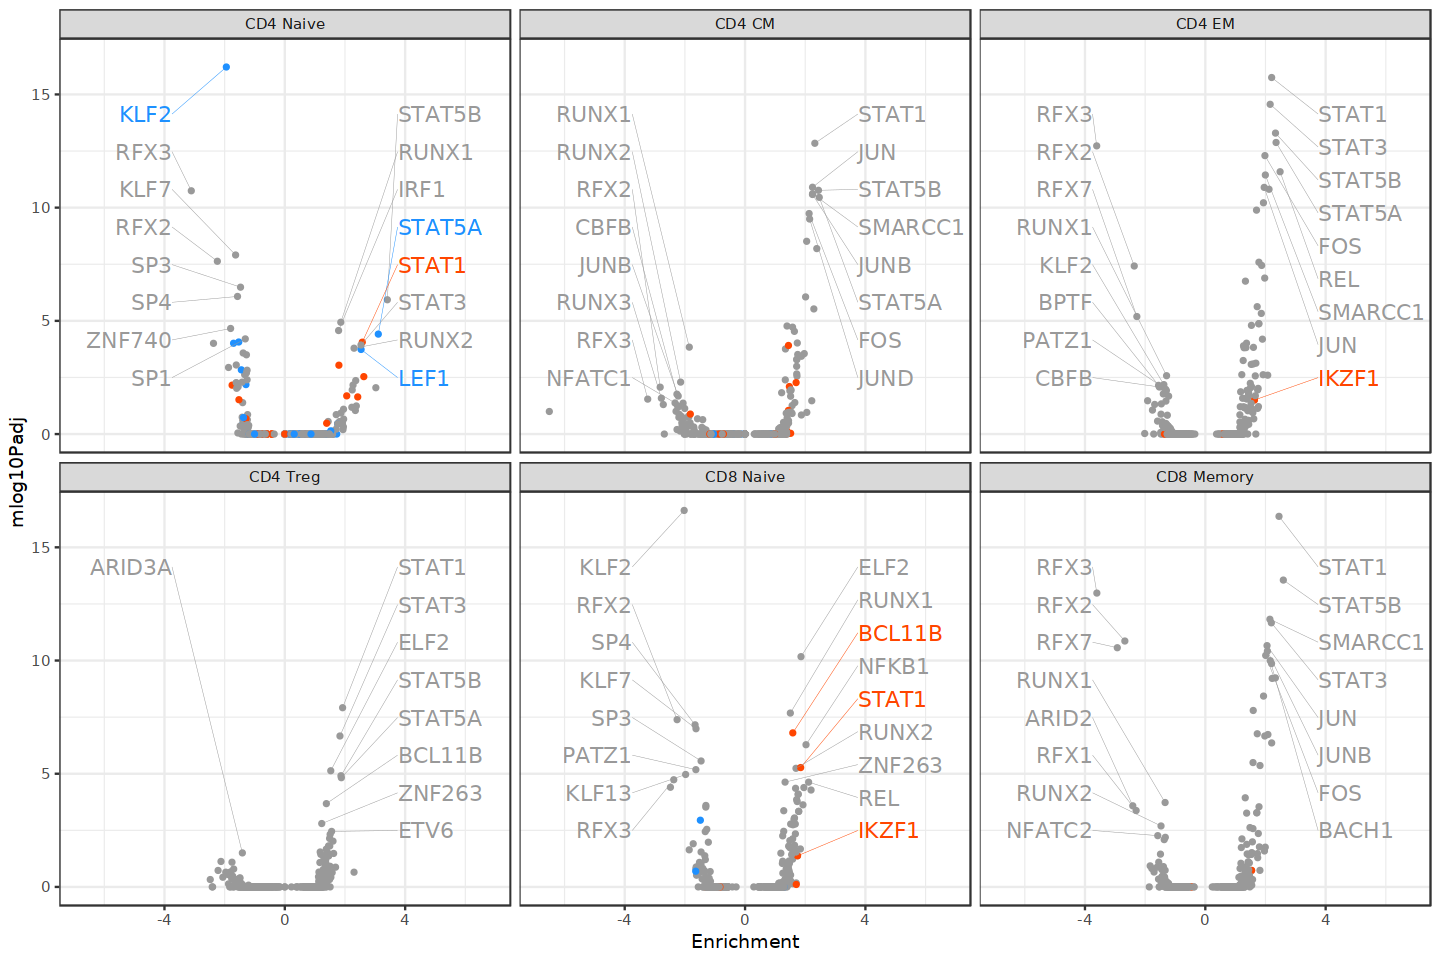

In [76]:
options(repr.plot.width = 12, repr.plot.height = 8)

volcano_plots <- ggplot() +
  geom_point(
      data = plot_dem,
      aes(x = Enrichment,
          y = mlog10Padj,
          color = color),
      size = 1
  ) +
  geom_segment(
      data = up_label_dem,
      aes(x = xpos, xend = Enrichment,
          y = ypos, yend = mlog10Padj,
          color = color),
      linewidth = 0.1
  ) +
  geom_text(
      data = up_label_dem,
      aes(x = xpos,
          y = ypos,
          color = color,
          label = tf_gene),
      size = 4.5,
      hjust = 0
  ) +
  geom_segment(
      data = dn_label_dem,
      aes(x = xpos, xend = Enrichment,
          y = ypos, yend = mlog10Padj,
          color = color),
      linewidth = 0.1
  ) +
  geom_text(
      data = dn_label_dem,
      aes(x = xpos,
          y = ypos,
          color = color,
          label = tf_gene),
      size = 4.5,
      hjust = 1
  ) +
  scale_color_identity() +
  scale_x_continuous(
      limits = c(-2 * max_enrich, 2 * max_enrich)
  ) +
  facet_wrap(
      ~ cell_type_label,
      ncol = 3,
      nrow = 2
  ) +
  theme_bw()

volcano_plots

In [77]:
out_file <- file.path(
    out_dir,
    paste0("lenalidomide_24hr_dem_volcano_plots_",Sys.Date(),".pdf")
)
ggsave(out_file,
       volcano_plots,
       width = 12, height = 8)

# Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference.

In [78]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq Fig 4", Sys.Date())

In [79]:
out_files <- list.files(
    out_dir,
    full.names = TRUE
)
out_list <- as.list(out_files)

In [80]:
out_list

[[1]]
[1] "output/figure_4/lenalidomide_24hr_dem_data_2023-10-18.csv"

[[2]]
[1] "output/figure_4/lenalidomide_24hr_dem_volcano_plots_2023-10-18.pdf"

[[3]]
[1] "output/figure_4/lenalidomide_dap_barplot_2023-10-18.pdf"

[[4]]
[1] "output/figure_4/lenalidomide_dap_summary_data_2023-10-18.csv"

[[5]]
[1] "output/figure_4/lenalidomide_dde_barplot_2023-10-18.pdf"

[[6]]
[1] "output/figure_4/lenalidomide_dde_summary_data_2023-10-18.csv"

[[7]]
[1] "output/figure_4/lenalidomide_deg_barplot_2023-10-18.pdf"

[[8]]
[1] "output/figure_4/lenalidomide_deg_summary_data_2023-10-18.csv"

[[9]]
[1] "output/figure_4/lenalidomide_hallmark_heatmap_2023-10-18.pdf"

In [81]:
in_list <- c(deg_uuid, dep_uuid, dap_uuid, hallmark_uuid, dem_uuid)

In [82]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = in_list,
    store = "project",
    doPrompt = FALSE
)

[1] "Cannot determine the current notebook."
[1] "1) /home/jupyter/repro-vrd-tea-seq/figures/Fig-4_len_overview.ipynb"
[1] "2) /home/jupyter/repro-vrd-tea-seq/figures/Fig-2_bor_overview.ipynb"
[1] "3) /home/jupyter/repro-vrd-tea-seq/figures/Fig-6_dex_overview.ipynb"


Please select (1-3)  1


$files
$files[[1]]
[1] "output/figure_4/lenalidomide_24hr_dem_data_2023-10-18.csv"

$files[[2]]
[1] "output/figure_4/lenalidomide_24hr_dem_volcano_plots_2023-10-18.pdf"

$files[[3]]
[1] "output/figure_4/lenalidomide_dap_barplot_2023-10-18.pdf"

$files[[4]]
[1] "output/figure_4/lenalidomide_dap_summary_data_2023-10-18.csv"

$files[[5]]
[1] "output/figure_4/lenalidomide_dde_barplot_2023-10-18.pdf"

$files[[6]]
[1] "output/figure_4/lenalidomide_dde_summary_data_2023-10-18.csv"

$files[[7]]
[1] "output/figure_4/lenalidomide_deg_barplot_2023-10-18.pdf"

$files[[8]]
[1] "output/figure_4/lenalidomide_deg_summary_data_2023-10-18.csv"

$files[[9]]
[1] "output/figure_4/lenalidomide_hallmark_heatmap_2023-10-18.pdf"


$traceId
[1] "98c36b40-29f2-4dc6-92dd-7b3933cc0d44"

In [83]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.1 ggrepel_0.9.3 ggplot2_3.4.3 dplyr_1.1.3   purrr_1.0.2  
[6] hise_2.16.0  

loaded via a namespace (and not attached):
 [1] gtable_0.3.4      jsonlite_1.8.7    compiler_4.3.1    crayon_1.5.2     
 [5] tidyselect_1.2.0  Rcpp_1.0.11       IRdisplay_1.1     bitops_1.0-7     
 [9] assertthat_0.2.1  